In [1]:
import pandas as pd
import numpy as np
import wrangle, scale, explore, cluster, evaluate
import warnings
warnings.filterwarnings("ignore")

## Wrangle 

In [2]:
zillow = wrangle.get_all_zillow_data()
zillow = zillow.sort_values('transactiondate').drop_duplicates('parcelid',keep='last')

In [3]:
zillow.shape

(77381, 69)

In [4]:
col, row = wrangle.get_nulls(zillow)

<class 'pandas.core.series.Series'>


In [5]:
#drop any col missing 30% of its data
zillow = wrangle.drop_null_columns(zillow,30)

<class 'pandas.core.series.Series'>


In [6]:
#drop any row missing 70% of its data
zillow = wrangle.drop_null_rows(zillow, 70)

In [7]:
#drop remaining data
zillow = zillow.dropna()

In [8]:
zillow.isna().sum().sum()

0

In [9]:
zillow.shape

(64065, 30)

In [10]:
for i in zillow.columns:
    print(zillow[i].value_counts())

261.0    50560
266.0    11316
269.0     1767
265.0      311
263.0       58
267.0       29
275.0        9
260.0        9
246.0        5
264.0        1
Name: propertylandusetypeid, dtype: int64
12551841    1
13909805    1
11919121    1
11388690    1
12838678    1
           ..
17051872    1
13096111    1
11582003    1
12715912    1
12853244    1
Name: parcelid, Length: 64065, dtype: int64
0        1
7529     1
73033    1
66890    1
68939    1
        ..
39494    1
37447    1
59976    1
62027    1
2047     1
Name: id, Length: 64065, dtype: int64
0.002652    7
0.000231    7
0.008257    5
0.006909    5
0.003152    5
           ..
0.033095    1
0.423427    1
0.020736    1
0.046424    1
0.025578    1
Name: logerror, Length: 63643, dtype: int64
2017-06-30    975
2017-04-28    758
2017-05-31    716
2017-07-28    686
2017-03-31    650
             ... 
2018-05-25      1
2017-05-13      1
2017-08-13      1
2017-06-03      1
2017-09-02      1
Name: transactiondate, Length: 263, dtype: int64
223232

### Feature Engineering 

In [11]:
zillow = wrangle.zillow_engineering(zillow)

In [12]:
#filter by single unit housing
zillow = zillow[(zillow.propertylandusedesc == 'Single Family Residential') |
          (zillow.propertylandusedesc == 'Mobile Home') |
          (zillow.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
          (zillow.propertylandusedesc == 'Townhouse')]
zillow.shape

(50628, 32)

In [13]:
zillow.columns

Index(['propertylandusetypeid', 'parcelid', 'id', 'logerror',
       'transactiondate', 'id.1', 'bathroomcnt', 'bedroomcnt',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'propertylandusedesc', 'taxrate',
       'transactionmonth'],
      dtype='object')

## Split/Scale

In [14]:
train , validate, test = wrangle.split_for_model(zillow)
train_scaled, validate_scaled, test_scaled = scale.scale_data(train, validate, test, 'MinMax',\
                                                              to_scale=['calculatedfinishedsquarefeet','latitude','longitude',\
                                                                        'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
                                                                        'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12'])

train(28351, 32),validate(12151, 32),test(10126, 32)


## Explore

### Exploring Variables in relation to Target = Log Error

In [15]:
cont_vars = ['logerror','calculatedfinishedsquarefeet','latitude','longitude','lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
             'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12', 'transactionmonth','bathroomcnt','bedroomcnt' , 'regionidzip']
target = 'logerror'

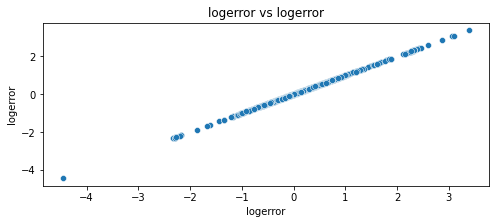

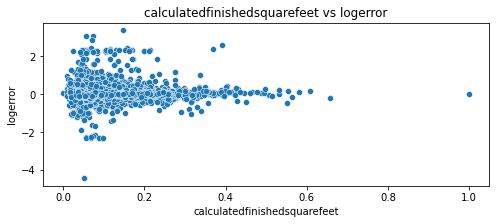

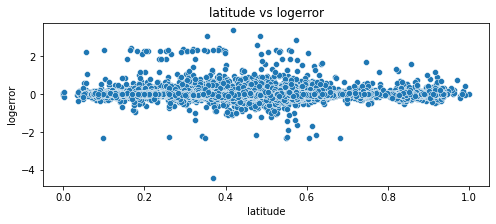

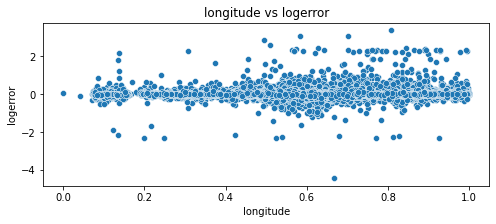

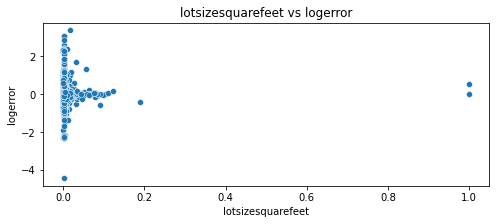

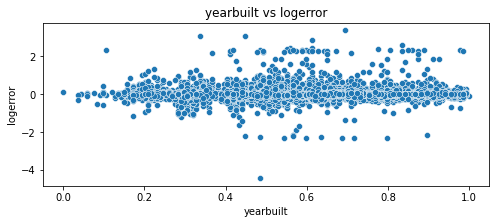

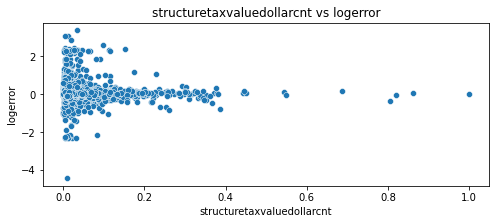

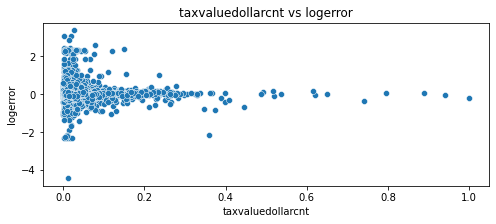

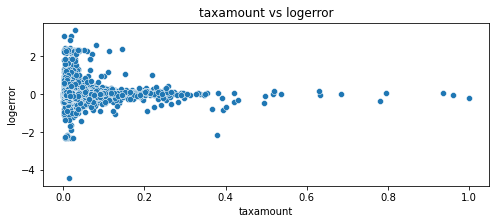

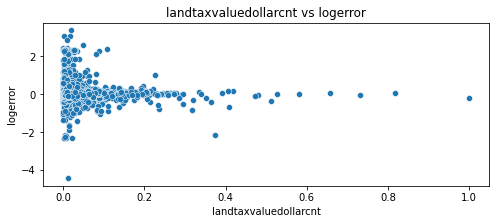

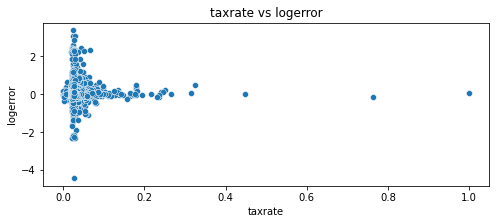

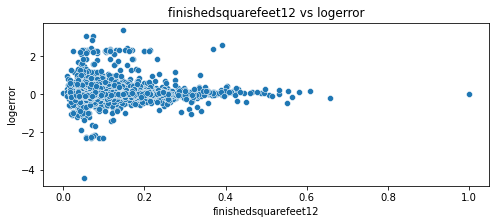

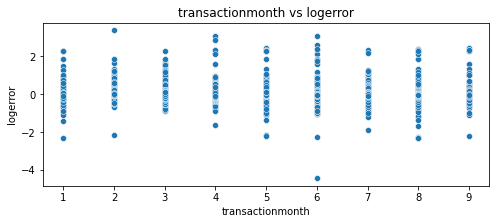

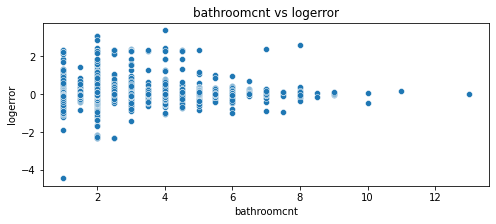

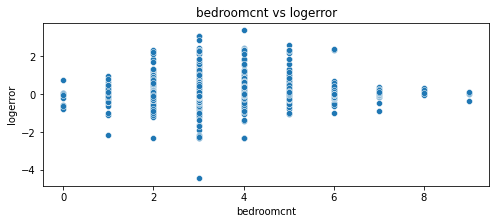

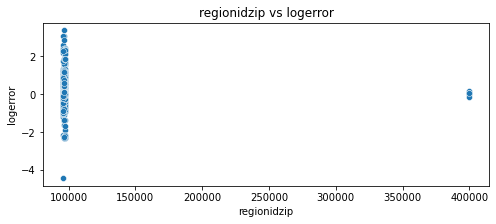

In [16]:
explore.compare_to_target(train_scaled[cont_vars], target)

## Take Aways
- Pricing, Size, and Age of the house play a big role in Log Error 
- The more houses are similar to eachother in terms of these 3 main topics , the harder it is to predict there price accurately
    * Why? maybe our data needs to know more about its position?
- we will look more into location vs price vs size , cluster these and see if these types of houses prioritize diffrent drivers for predicting logerror and model to their needs for a possibly better Predicitons

## Target = Logerror 

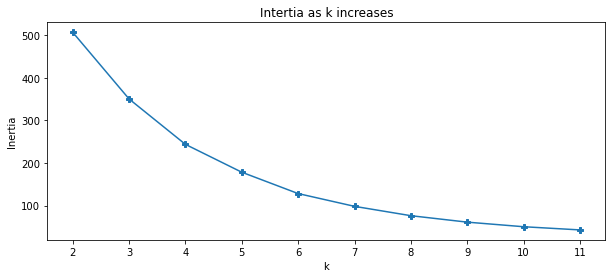

In [17]:
X = train_scaled[['logerror']]
cluster.view_intertia(X)

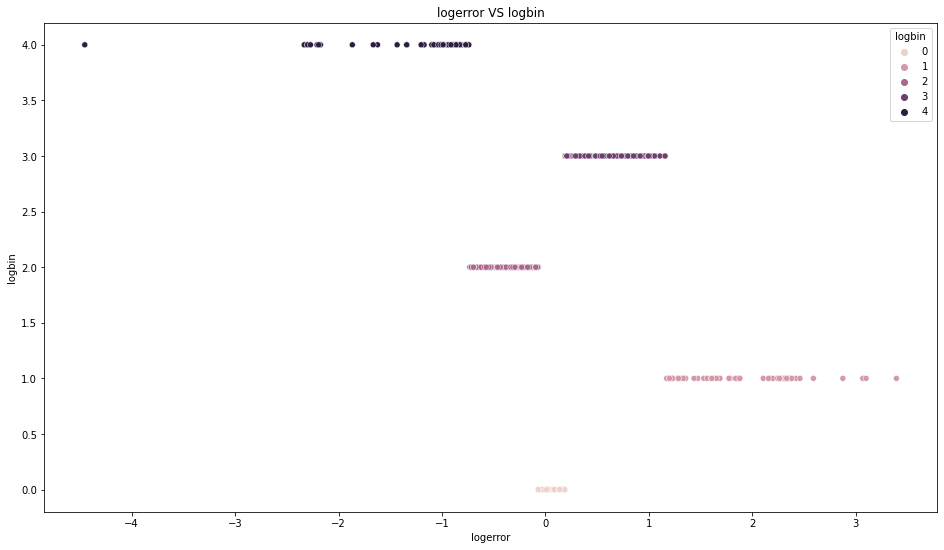

In [18]:
X = cluster.show_cluster(X, 5, 'logbin')

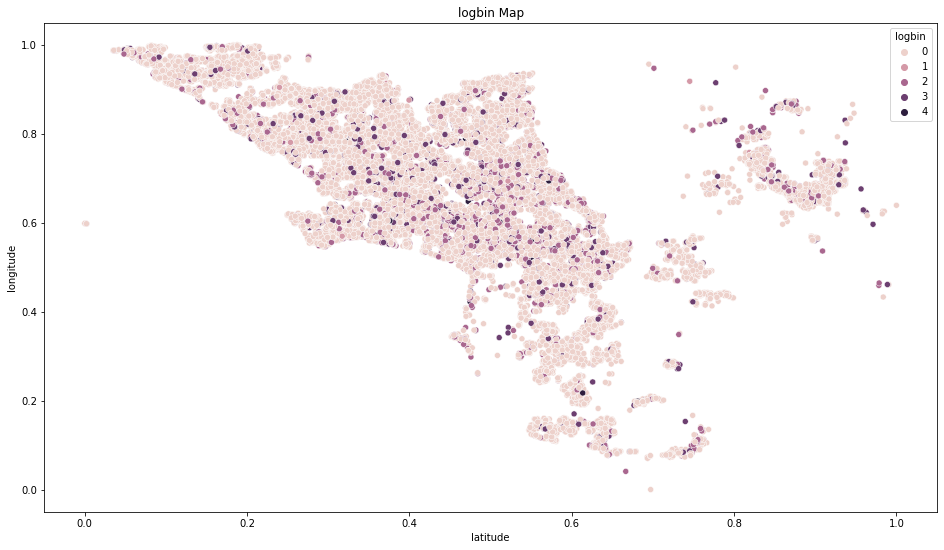

In [19]:
train_scaled['logbin'] = X['logbin']
cluster.map_clusters(train_scaled, 'logbin')

### Price

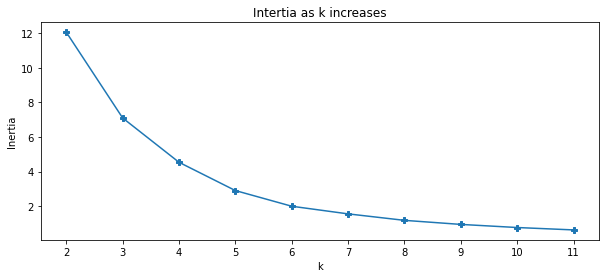

In [20]:
X = train_scaled[['taxvaluedollarcnt']]
cluster.view_intertia(X)

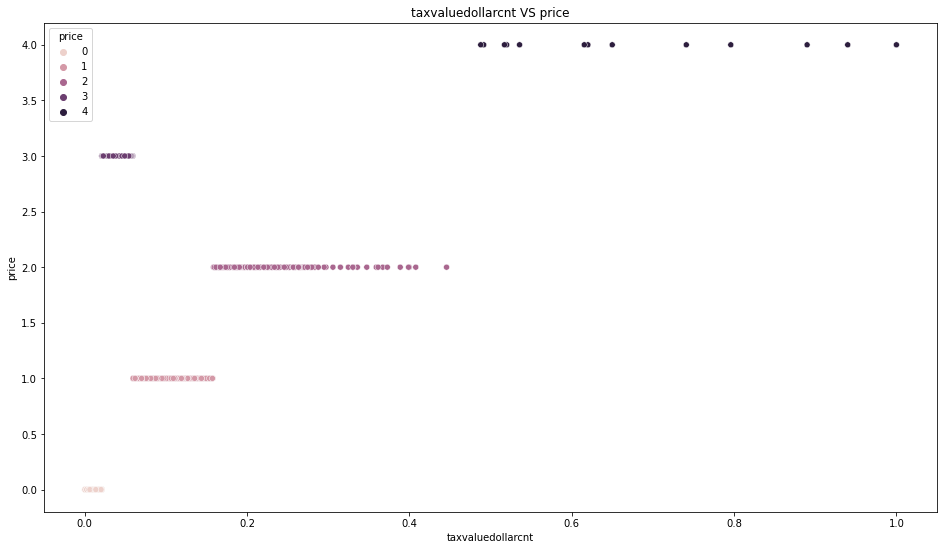

In [21]:
X = cluster.show_cluster(X, 5, 'price')

In [22]:
#Add clusters onto existing training dataset
train_scaled['price'] = X['price']

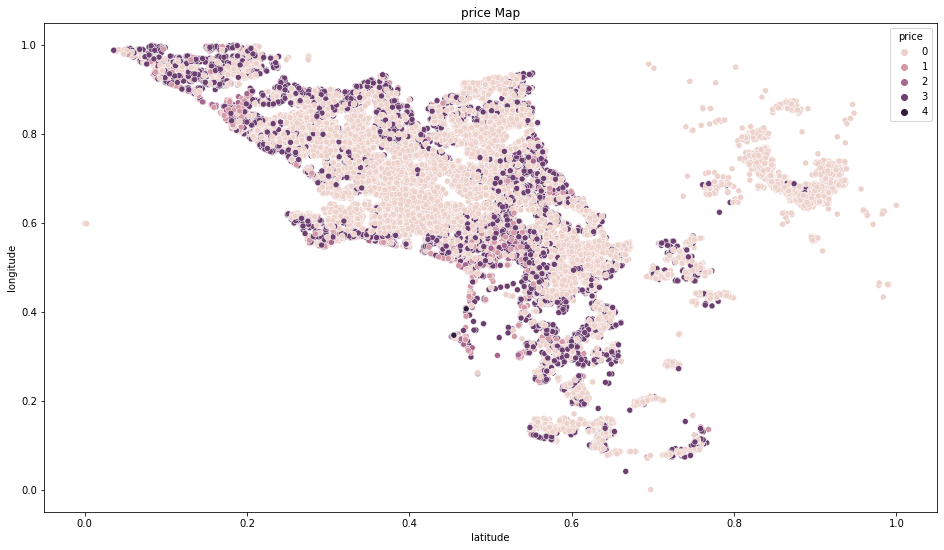

In [23]:
cluster.map_clusters(train_scaled, 'price')

### Size

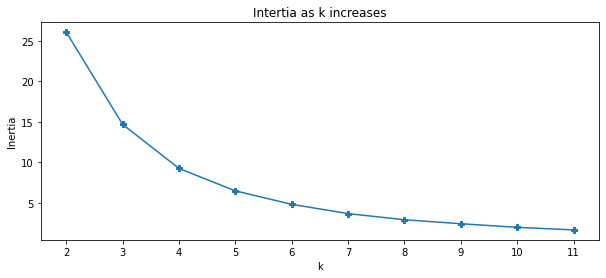

In [24]:
X = train_scaled[['calculatedfinishedsquarefeet']]
cluster.view_intertia(X)

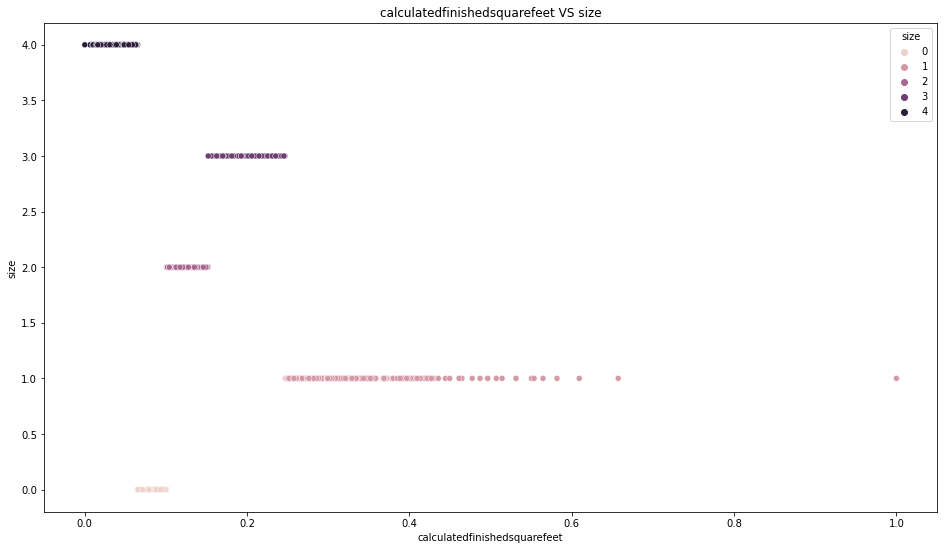

In [25]:
X = cluster.show_cluster(X, 5, 'size')

In [26]:
train_scaled['size'] = X['size']

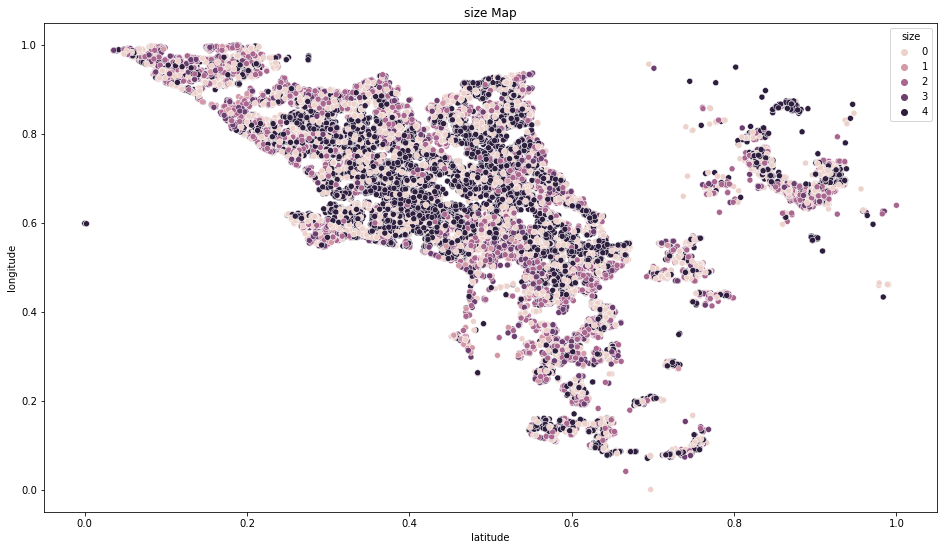

In [27]:
cluster.map_clusters(train_scaled, 'size')

### Age

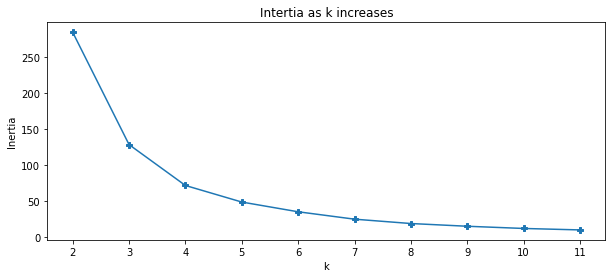

In [28]:
X = train_scaled[['yearbuilt']]
cluster.view_intertia(X)

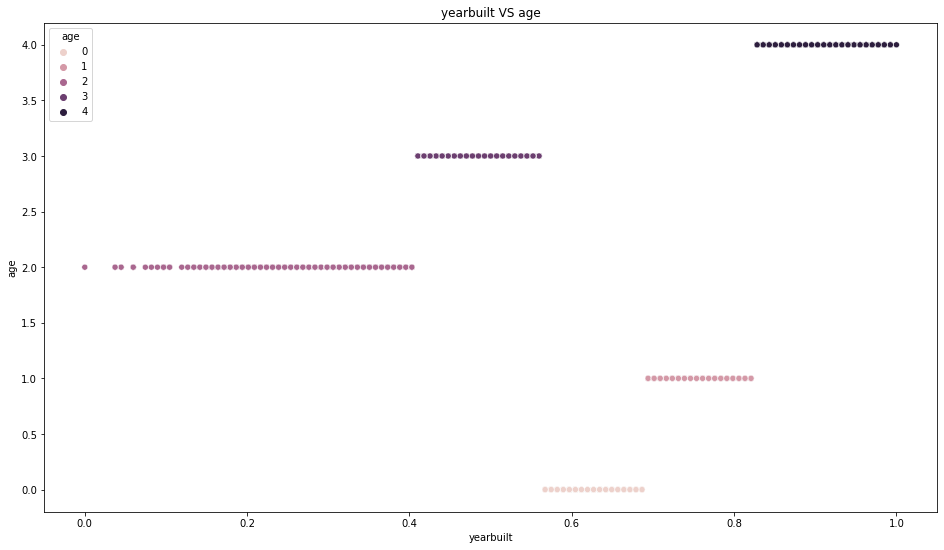

In [29]:
X = cluster.show_cluster(X, 5, 'age')

In [30]:
train_scaled['age'] = X['age']

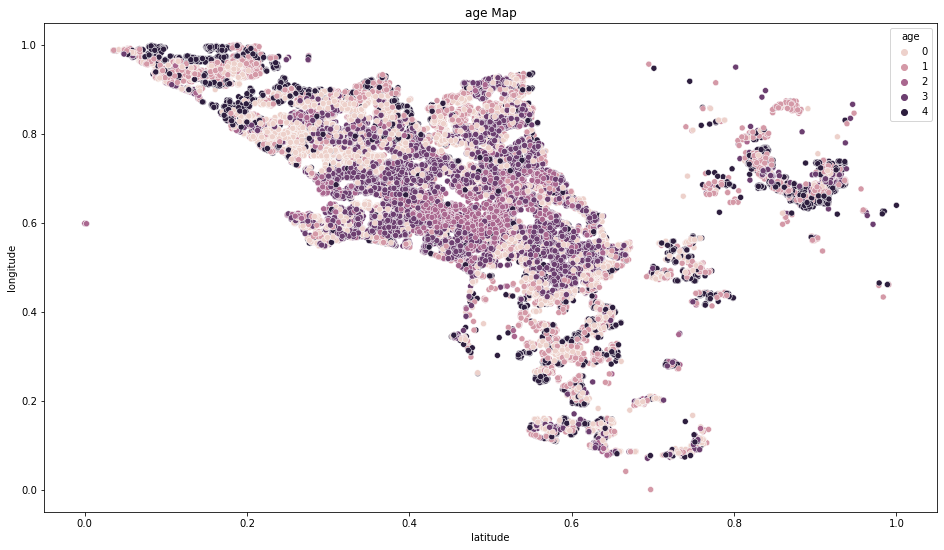

In [31]:
cluster.map_clusters(train_scaled, 'age')

## Cross Referencing our Big 3

### Size vs Price

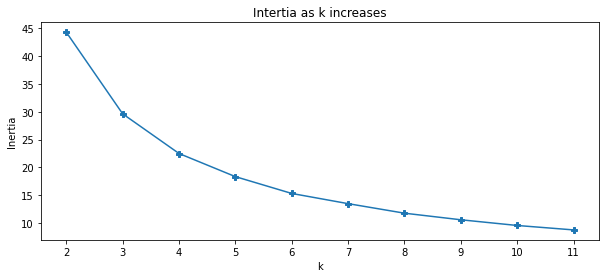

In [32]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
cluster.view_intertia(X)

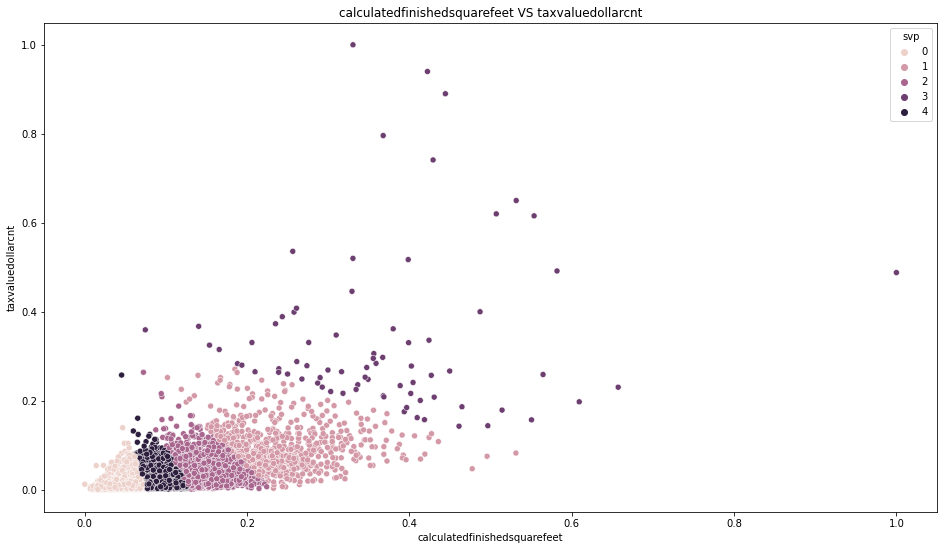

In [33]:
#Price by Size
X = cluster.show_cluster(X, 5, 'svp')

In [34]:
train_scaled['svp'] = X['svp']

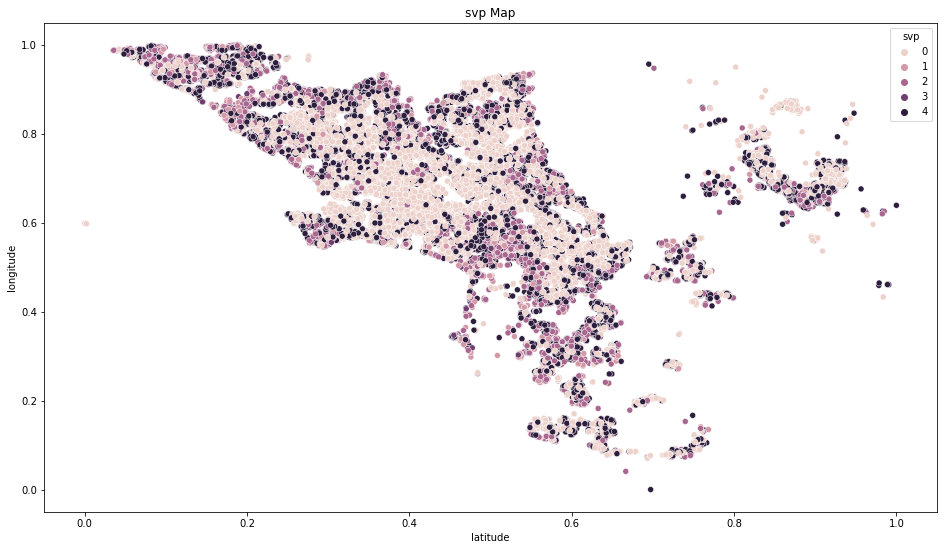

In [35]:
cluster.map_clusters(train_scaled, 'svp')

### Price vs Age

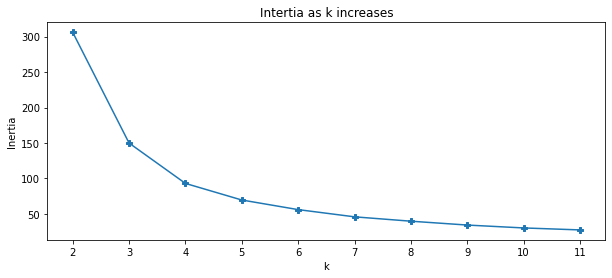

In [36]:
X = train_scaled[['taxvaluedollarcnt', 'yearbuilt']]
cluster.view_intertia(X)

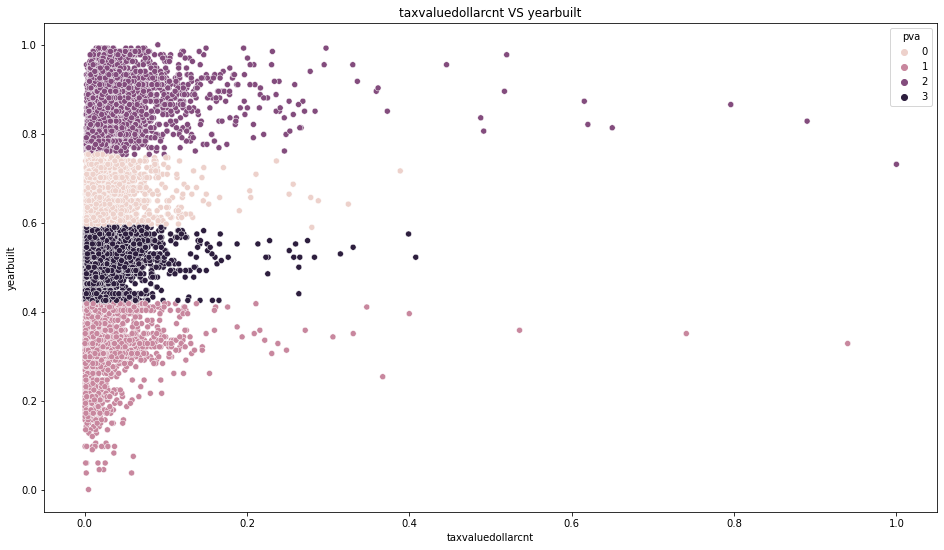

In [37]:
#price per age
X = cluster.show_cluster(X, 4, 'pva')

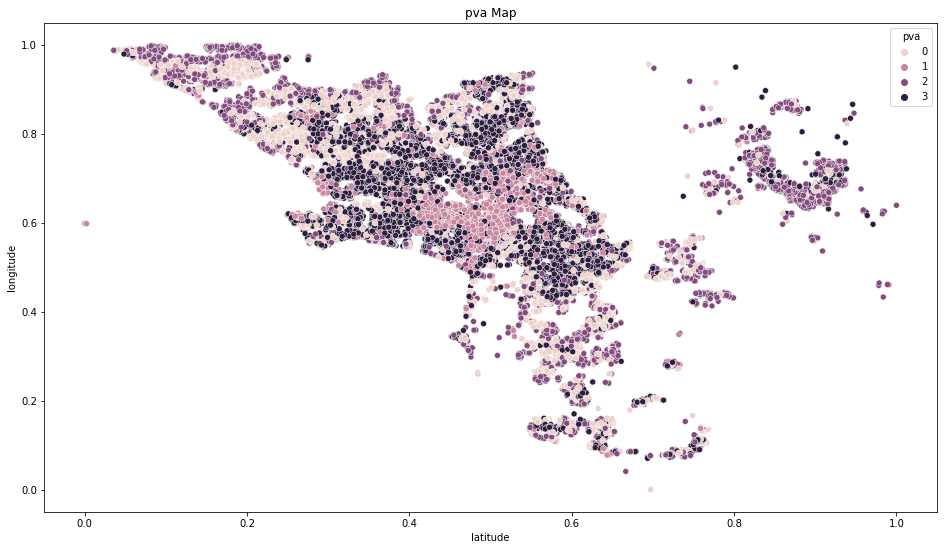

In [38]:
train_scaled['pva'] = X['pva']
cluster.map_clusters(train_scaled, 'pva')

### Age vs Size

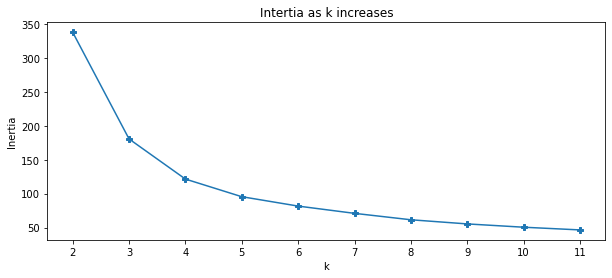

In [39]:
X = train_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
cluster.view_intertia(X)

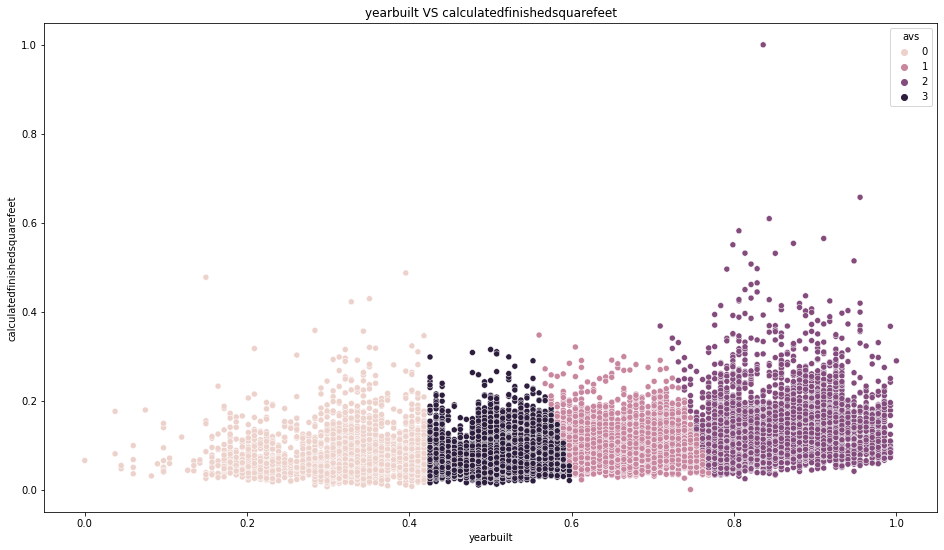

In [40]:
X = cluster.show_cluster(X, 4, 'avs')

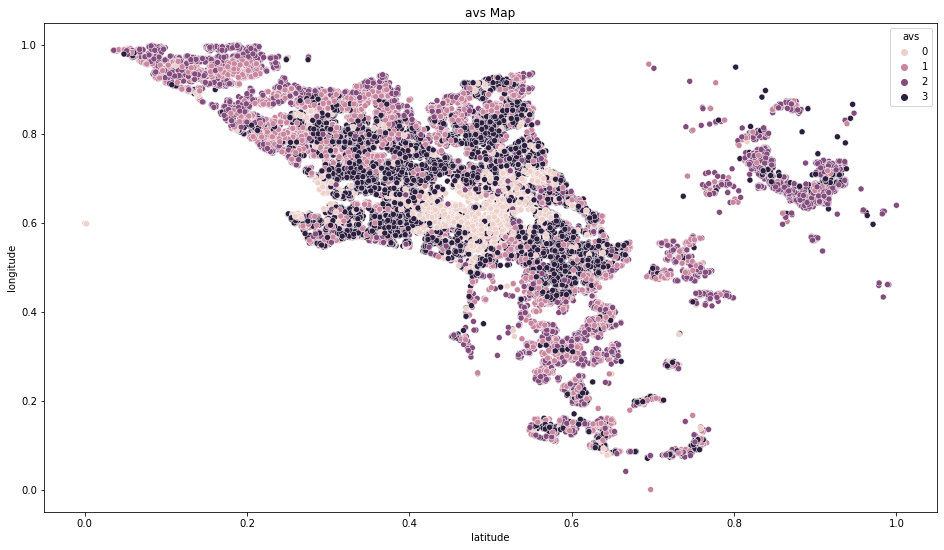

In [41]:
train_scaled['avs'] = X['avs']
cluster.map_clusters(train_scaled, 'avs')

## All 3

### Size vs Price vs Age

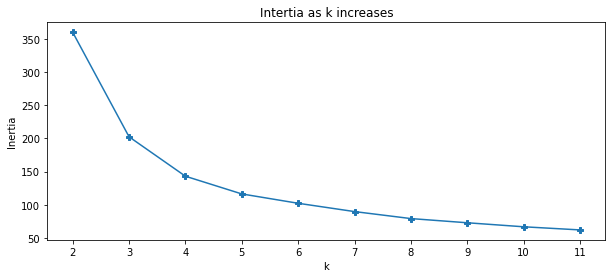

In [42]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
cluster.view_intertia(X)

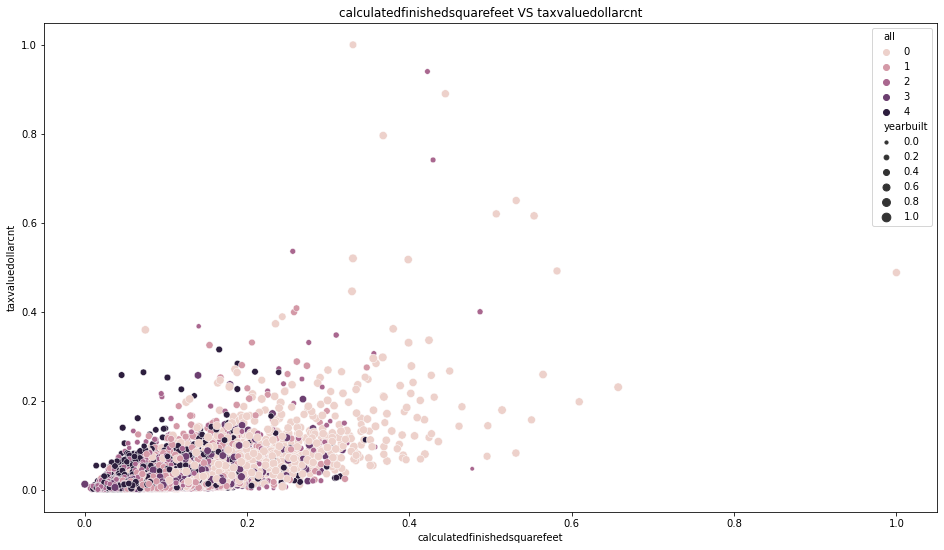

In [43]:
X = cluster.show_cluster(X, 5, 'all', 'yearbuilt')

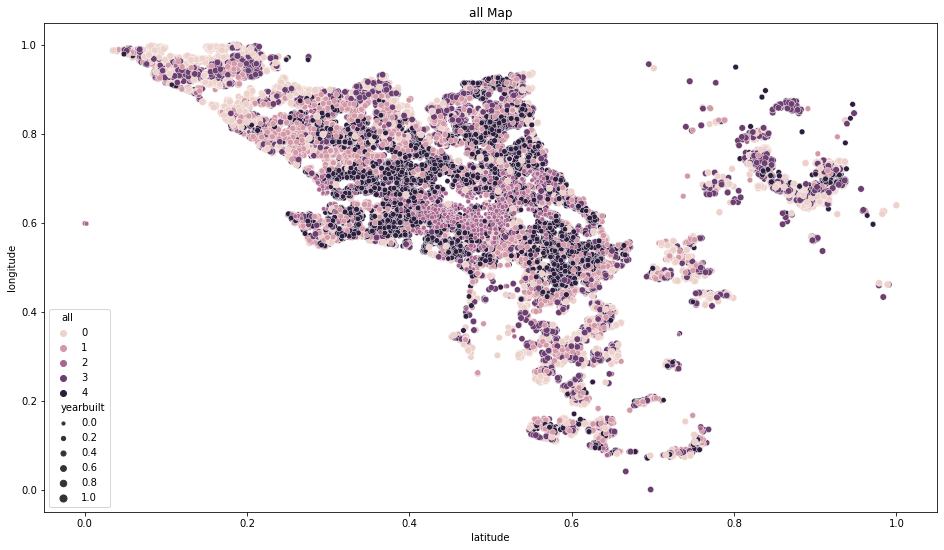

In [44]:
train_scaled['all'] = X['all']
cluster.map_clusters(train_scaled, 'all', 'yearbuilt' )

### Find Trend

In [45]:
X = train_scaled[['logerror']]
X = cluster.show_cluster(X, 5, 'logbin',hide= True)
train_scaled['logbin'] = X['logbin']

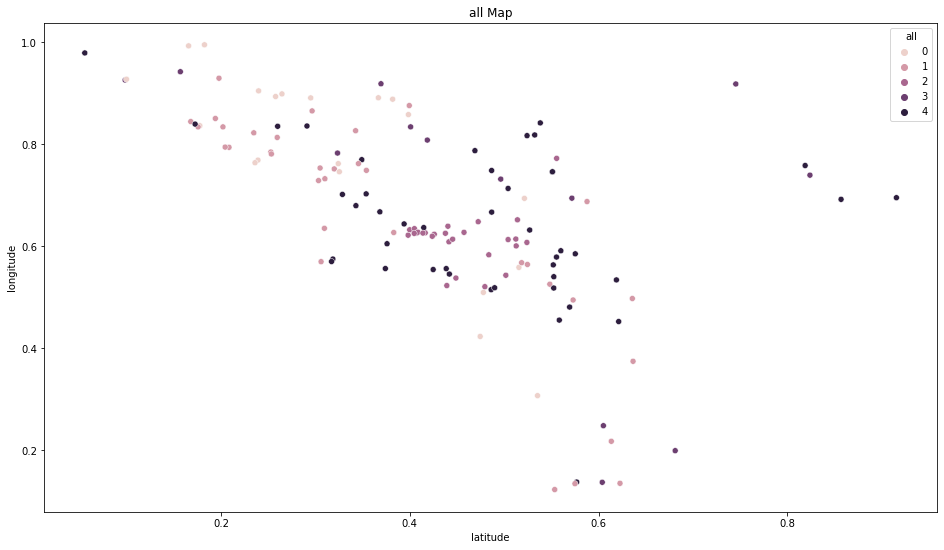

In [46]:
cluster.map_clusters(train_scaled[(train_scaled['logbin']== 4) | (train_scaled['logbin']== 1)], 'all')

## Major Takeaway 
- Majority of the houses that had the most log error are either cheaper, or smaller

- There are more cheaper and smaller houses in the dataset, do they need there own model to be accurate?

### Next steps
##### 1. Do Different price markets have different drivers for predicting log error
##### 2. Do the bins created help or hinder predicting log error? 
##### 3. Do cheaper markets need to have an entirely different model in order to be accurate in predictiong log error.

### 1. Do each housing markets priorities differnt drivers



In [47]:
#Set clusters to validate and test 

In [48]:
#---Validate---
X = validate_scaled[['taxvaluedollarcnt']]
X = cluster.show_cluster(X, 5, 'price',hide= True)
validate_scaled['price'] = X['price']

X = validate_scaled[['calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 5, 'size',hide= True)
validate_scaled['size'] = X['size']

X = validate_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 5, 'age',hide= True)
validate_scaled['age'] = X['age']

X = validate_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 5, 'svp',hide= True)
validate_scaled['svp'] = X['svp']

X = validate_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'pva',hide= True)
validate_scaled['pva'] = X['pva']

X = validate_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'avs',hide= True)
validate_scaled['avs'] = X['avs']

X = validate_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 5, 'all',size = 'yearbuilt',hide= True)
validate_scaled['all'] = X['all']

#---Test---
X = test_scaled[['taxvaluedollarcnt']]
X = cluster.show_cluster(X, 5, 'price',hide= True)
test_scaled['price'] = X['price']

X = test_scaled[['calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 5, 'size',hide= True)
test_scaled['size'] = X['size']

X = test_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 5, 'age',hide= True)
validate_scaled['age'] = X['age']

X = test_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 5, 'svp',hide= True)
test_scaled['svp'] = X['svp']

X = test_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'pva',hide= True)
test_scaled['pva'] = X['pva']

X = test_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'avs',hide= True)
test_scaled['avs'] = X['avs']

X = test_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 5, 'all',size = 'yearbuilt',hide= True)
test_scaled['all'] = X['all']

In [49]:
#drop non-numerical columns and id columns for modeling, drop logbin for modeling

In [50]:
train_scaled = train_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc','logbin'])
validate_scaled = validate_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])
test_scaled = test_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])

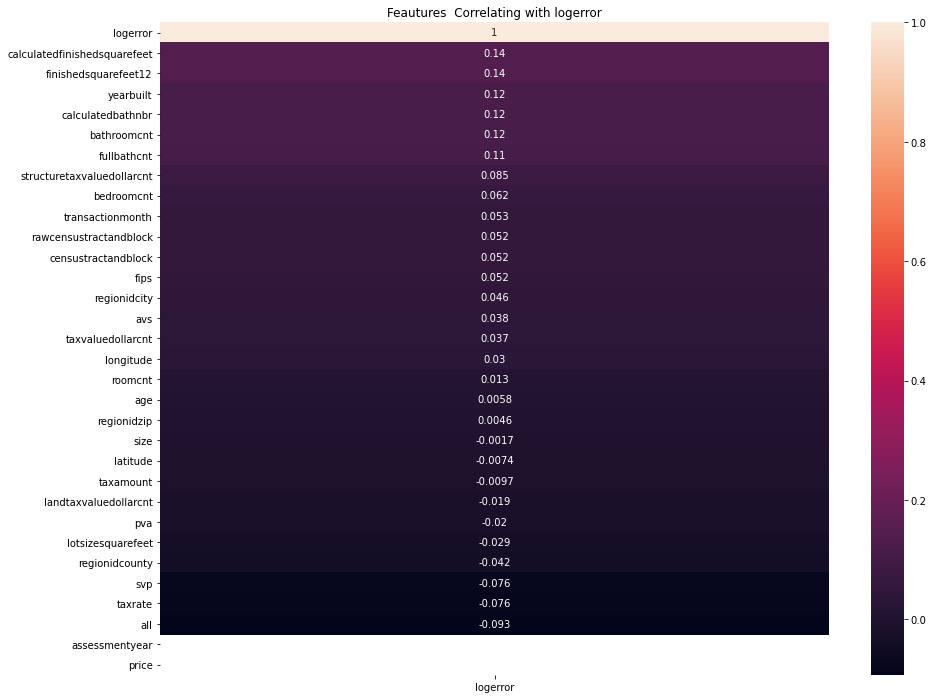

<AxesSubplot:title={'center':'Feautures  Correlating with logerror'}>

In [80]:
explore.get_heatmap(train_scaled[train_scaled['price'] == 1], 'logerror')

### Drivers

In [52]:
X_train = train_scaled.drop(columns=['logerror'])
y_train = train_scaled[['logerror','price']]

X_validate = validate_scaled.drop(columns=['logerror'])
y_validate = validate_scaled[['logerror','price']]

X_test = test_scaled.drop(columns=['logerror'])
y_test = test_scaled[['logerror','price']]

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

#### K-Best
- Look at top 10 drivers for each market

In [81]:
kbest0 = evaluate.select_kbest(evaluate.get_price(X_train,0),evaluate.get_price(y_train,0), 10)
kbest1 = evaluate.select_kbest(evaluate.get_price(X_train,1),evaluate.get_price(y_train,1), 10)
kbest2 = evaluate.select_kbest(evaluate.get_price(X_train,2),evaluate.get_price(y_train,2), 10)
kbest3 = evaluate.select_kbest(evaluate.get_price(X_train,3),evaluate.get_price(y_train,3), 10)
kbest4 = evaluate.select_kbest(evaluate.get_price(X_train,4),evaluate.get_price(y_train,4), 10)

In [82]:
kbest0, kbest1

(['bedroomcnt',
  'calculatedfinishedsquarefeet',
  'finishedsquarefeet12',
  'lotsizesquarefeet',
  'structuretaxvaluedollarcnt',
  'taxvaluedollarcnt',
  'landtaxvaluedollarcnt',
  'taxamount',
  'taxrate',
  'transactionmonth'],
 ['bathroomcnt',
  'calculatedbathnbr',
  'calculatedfinishedsquarefeet',
  'finishedsquarefeet12',
  'fullbathcnt',
  'yearbuilt',
  'structuretaxvaluedollarcnt',
  'taxrate',
  'svp',
  'all'])

In [83]:
rfe0 = evaluate.select_rfe(evaluate.get_price(X_train,0),evaluate.get_price(y_train,0), 5)
rfe1 = evaluate.select_rfe(evaluate.get_price(X_train,1),evaluate.get_price(y_train,1), 5)
rfe2 = evaluate.select_rfe(evaluate.get_price(X_train,2),evaluate.get_price(y_train,2), 5)
rfe3 = evaluate.select_rfe(evaluate.get_price(X_train,3),evaluate.get_price(y_train,3), 5)
rfe4 = evaluate.select_rfe(evaluate.get_price(X_train,4),evaluate.get_price(y_train,4), )

In [79]:
rfe0, rfe0

(['bathroomcnt',
  'bedroomcnt',
  'calculatedbathnbr',
  'calculatedfinishedsquarefeet',
  'finishedsquarefeet12',
  'fullbathcnt',
  'latitude',
  'longitude',
  'lotsizesquarefeet',
  'yearbuilt',
  'structuretaxvaluedollarcnt',
  'taxvaluedollarcnt',
  'landtaxvaluedollarcnt',
  'taxamount',
  'taxrate',
  'transactionmonth',
  'size',
  'age',
  'pva',
  'avs'],
 ['bathroomcnt',
  'bedroomcnt',
  'calculatedbathnbr',
  'calculatedfinishedsquarefeet',
  'finishedsquarefeet12',
  'fullbathcnt',
  'latitude',
  'longitude',
  'lotsizesquarefeet',
  'yearbuilt',
  'structuretaxvaluedollarcnt',
  'taxvaluedollarcnt',
  'landtaxvaluedollarcnt',
  'taxamount',
  'taxrate',
  'transactionmonth',
  'size',
  'age',
  'pva',
  'avs'])